Basic random forest classifier using finalised preprocessing pipeline

In [10]:
# different imports
import pandas as pd
import numpy as np
import os
import pickle

import pandas as pd
import numpy as np
import os
import numbers
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

#maybe put them with respective code
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

Loading preprocessed data:

In [11]:
# Import data that has already been preprocessed
data_dir = os.getcwd()
with open(os.path.join(data_dir, "Processing", r"train_preproc.p"), 'rb') as data_file:
    train_data = pickle.load(data_file)
X_train, y_train = train_data[0], train_data[1]

with open(os.path.join(data_dir, "Processing", r"test_preproc.p"), 'rb') as data_file:
    test_data = pickle.load(data_file)
X_test, y_test = test_data[0], test_data[1]



X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))


In [12]:
#Training the Algorithm
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=7, n_estimators=20, random_state=0)
# parameters to be adjusted to make most optimal 

from ModelEvaluationTools.SKEvaluator import SKEvaluator
rf_model = SKEvaluator(classifier, "rf")


In [17]:
rf_model.fit(X_train, y_train)

In [18]:
test_auc = rf_model.evaluate(X_test, y_test)

Accuracy - Test: 0.9980083333333334
AUC - Test: 0.9291832069024224


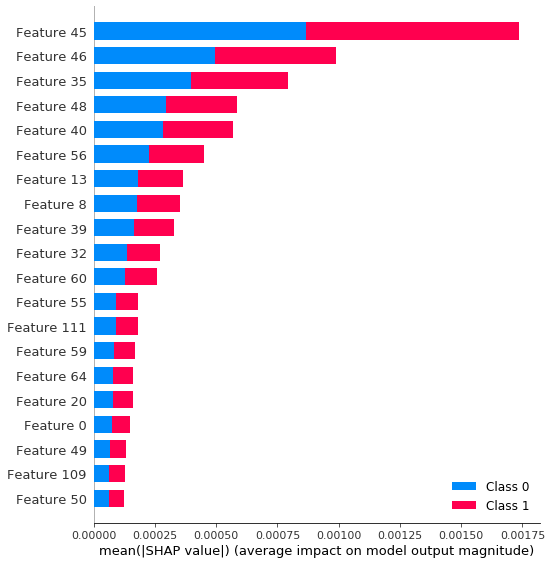

In [19]:
import shap

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X)


shap.summary_plot(shap_values, X, plot_type="bar")

Saves the model in the fitted_models folder.

In [20]:
rf_model.save_model()

In [25]:
with open("shap.txt", "wb") as fp:  
    pickle.dump(shap_values, fp)



In [27]:
w=pickle.load(open("shap.txt","rb"))
print(len(w[1]))

600000


In [28]:
w=pickle.load(open("shap.txt","rb"))[1]
weight = list(map(abs, w))
for k in range(0,600000) : 
    s = sum(weight[k])
    l = len(weight[k])
    a = 0
    for i in range(0, l - 1):
        weight[k][i] = weight[k][i] / s
        a = a + weight[k][i]
    weight[k][l - 1] = 1 - a

In [30]:
with open("weight.txt", "wb") as fp:  
    pickle.dump(weight, fp)